# Projection simulation
In this notebook, we plot the projections of one of the simulated galaxies used in the chapter 2 and 3 of the PhD. Data from the selected galaxies is **not** in this repository. First, we import the Python packages.

In [1]:
import os

import cv2
import sphviewer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table, hstack, join

## Standard Plot Format
Setup the standard plotting format and make the plot.

In [2]:
# graphic aspect ratio = width/height
ASPECT = 8.0/8.0

# Text width in inches - don't change, this is defined by the print layout
TEXTWIDTH = 5.14  # inches

# output format and resolution
FIG_FMT = 'pdf'
DPI = 300

# Graphic dimensions
PLT_W = DPI*TEXTWIDTH
PLT_H = PLT_W/ASPECT
AX_FONTSIZE = 10
LAB_FONTSIZE = 8
LWIDTH = 0.5
AX_PAD = 3
WINCHES = TEXTWIDTH
HINCHES = WINCHES/ASPECT

# LaTeX is used throughout for markup of symbols, Times-Roman serif font
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif',
       'serif': ['Times-Roman'], 'weight': 'bold', 'size': '16'})

# Font and line weight defaults for axes
matplotlib.rc('axes', linewidth=LWIDTH)
matplotlib.rcParams.update({'font.size': AX_FONTSIZE})

# axis and label padding
plt.rcParams['xtick.major.pad'] = f'{AX_PAD}'
plt.rcParams['ytick.major.pad'] = f'{AX_PAD}'
plt.rcParams['axes.labelpad'] = f'{AX_PAD}'

## Reading galaxy estimations
**WARNING**: The following file used coming from the simulations has a size of ~315 MB, therefore we do not include it in the repository and the rest of the code is here as an example.

In [3]:
GAL_ID = 45 # or 13, 17 and random (100), 21 seems to be the best to show the differences

In [4]:
gas = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(GAL_ID)+'.hdf5',
                 format='hdf5', path='Gas')
gas_l = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(GAL_ID)+'.hdf5',
                   format='hdf5', path='GasnTL')
gmc = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(GAL_ID)+'.hdf5',
                 format='hdf5', path='GMC')
gmc_l = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(GAL_ID)+'.hdf5',
                   format='hdf5', path='GMCnTL')
rgas = hstack([gas, gas_l])
rgmc = hstack([gmc, gmc_l])
sum_gmc = rgmc.group_by('ParentSPH').groups.aggregate(np.sum)
sum_gmc.rename_column('ParentSPH', 'ParticleIDs')
sph_all = join(rgas, sum_gmc, keys='ParticleIDs', join_type='left')

In [5]:
stars = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(GAL_ID)+'.hdf5',
                   format='hdf5', path='Stars')
sum_stars = stars.group_by(['CoordX',
                            'CoordY',
                            'CoordZ']).groups.aggregate(np.sum)

In [6]:
pos = np.array([(sph_all['CoordX_1']*u.cm).to(u.kpc).value,
                (sph_all['CoordY_1']*u.cm).to(u.kpc).value,
                (sph_all['CoordZ_1']*u.cm).to(u.kpc).value])

In [7]:
print("Number of stars particles: %d"%len(sum_stars))
print("Number of stars particles: %d"%len(sph_all))
print("Number of neutral cloud particles: %d"%len(rgmc))

Number of stars particles: 139395
Number of stars particles: 16741
Number of neutral cloud particles: 134486


## Creating temporal images
We verify the angles we want to use by creating images at different angles. We also create a video to see the results and decide in the angle more quickly.
<!-- t=40 edge-on and t=130 face-on -->
<!-- p=10 face-on and p=100 edge-on -->

In [7]:
mass = (sph_all['Mass_1']*u.g).to(u.solMass)
particles = sphviewer.Particles(pos.T, mass)
scene = sphviewer.Scene(particles)
scene.update_camera(r=33)  # 33 work good
for p in range(0, 180):
    scene.update_camera(p=18, t=p, roll=90)
    render = sphviewer.Render(scene)
    render.set_logscale()
    img = render.get_image()
    extent = render.get_extent()
    plt.imshow(img, origin='lower', cmap='magma', vmin=4, vmax=9)
    plt.annotate('Val %3d' % p, xy=(0, 0), color='white')
    plt.savefig('../Data/temporal_images/snap_gas_%03d.png' % p)
    plt.clf()
#     plt.imsave('temporal_images/snap_gas_%03d.png' % p,
#                img, origin='lower', cmap='magma', vmin=4, vmax=9)

<Figure size 432x288 with 0 Axes>

In [8]:
images = ['snap_gas_%03d.png' % i for i in range(0, 360)]
IMAGE_FOLDER = '../Data/temporal_images'
VIDEO_NAME = 'exp.avi'
frame = cv2.imread(os.path.join(IMAGE_FOLDER, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(VIDEO_NAME, 0, 40, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(IMAGE_FOLDER, image)))

cv2.destroyAllWindows()
video.release()
print('Done creating video')

Done creating video


In [9]:
pos_gas = np.array([(sph_all['CoordX_1']*u.cm).to(u.kpc).value,
                    (sph_all['CoordY_1']*u.cm).to(u.kpc).value,
                    (sph_all['CoordZ_1']*u.cm).to(u.kpc).value])
pos_stars = np.array([(sum_stars['CoordX']*u.cm).to(u.kpc).value,
                      (sum_stars['CoordY']*u.cm).to(u.kpc).value,
                      (sum_stars['CoordZ']*u.cm).to(u.kpc).value])
positions = [pos_gas, pos_stars, pos_gas, pos_stars]
mass_gas = (sph_all['Mass_1']*u.g).to(u.solMass)
mass_stars = (sum_stars['Mass']*u.g).to(u.solMass)
masses = [mass_gas, mass_stars, mass_gas, mass_stars]

##### Figure

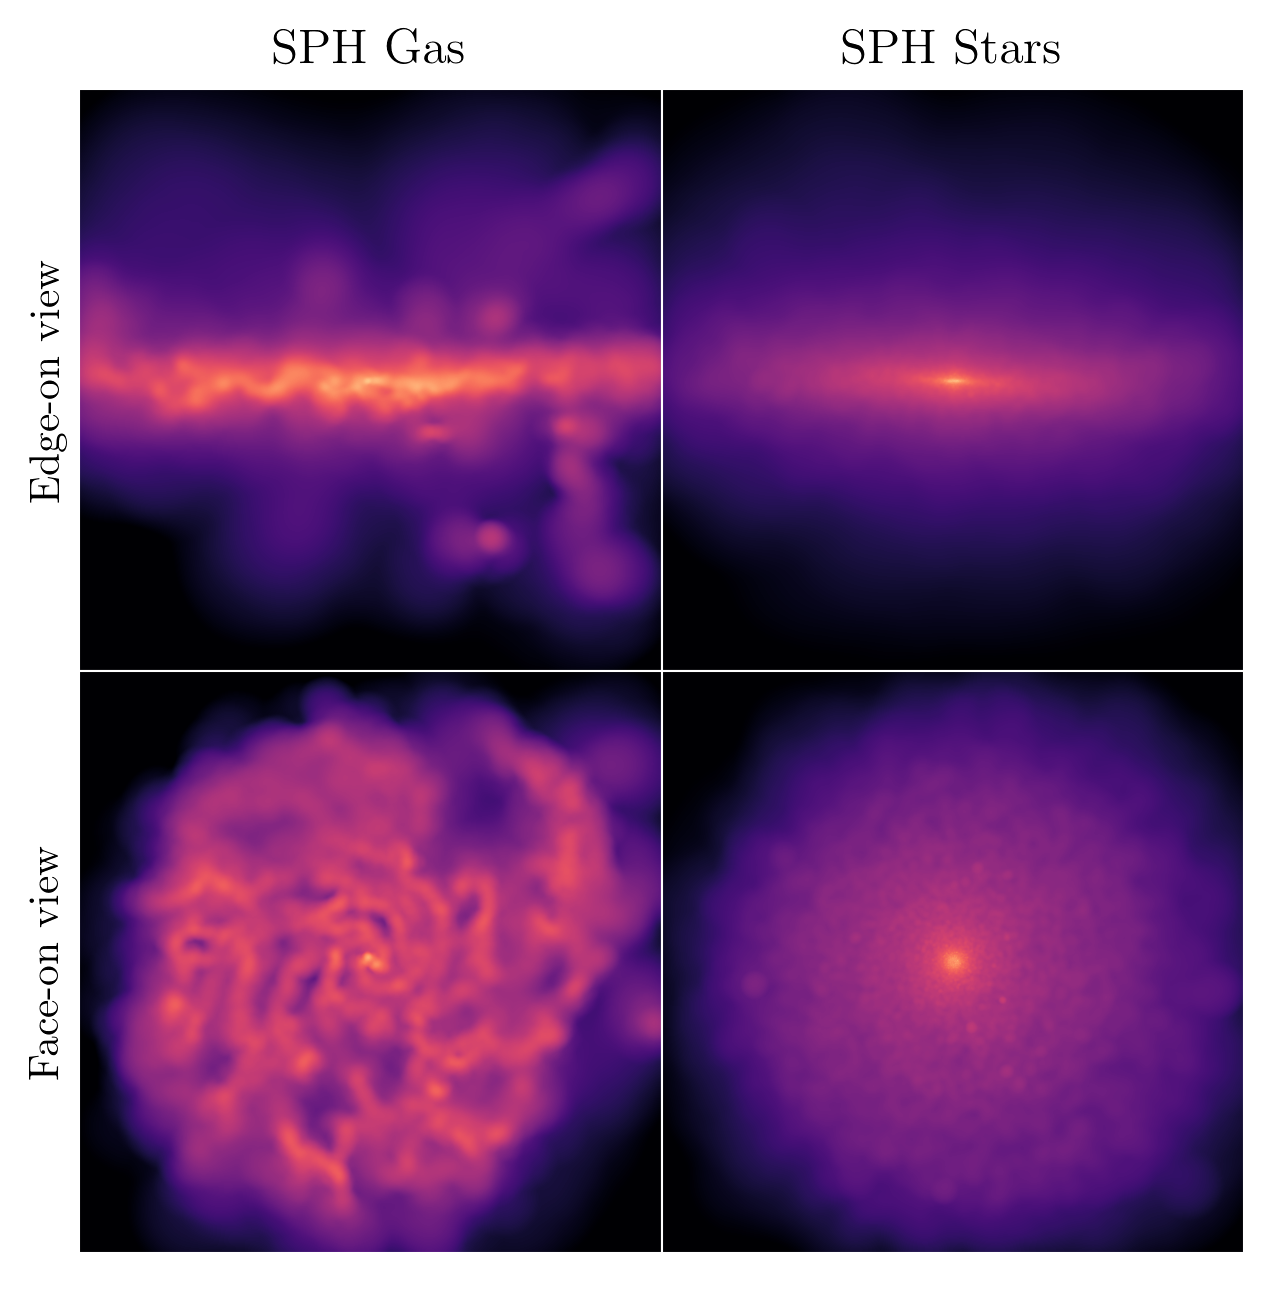

In [10]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_dpi(DPI)
fig.set_size_inches(WINCHES, HINCHES)
axs = axs.ravel()
for type_par in range(4):
    particles = sphviewer.Particles(positions[type_par].T, masses[type_par])
    scene = sphviewer.Scene(particles)
    scene.update_camera(r=33)  # 33 work good
    if type_par < 2:
        PVAL = 108
        TVAL = 45
    else:
        PVAL = 18
        TVAL = 52
    scene.update_camera(p=PVAL, t=TVAL, roll=90, xsize=2000, ysize=2000)
    render = sphviewer.Render(scene)
    render.set_logscale()
    img = render.get_image()
    extent = render.get_extent()
    if type_par in [0, 2]:
        axs[type_par].imshow(img, origin='lower',
                             cmap='magma', vmin=3.5, vmax=8.5)

    else:
        axs[type_par].imshow(img, origin='lower',
                             cmap='magma', vmin=5, vmax=12)
    plt.setp(axs[type_par].get_yticklabels(), visible=False)
    plt.setp(axs[type_par].get_xticklabels(), visible=False)
    axs[type_par].set_xticks([])
    axs[type_par].set_yticks([])
    axs[type_par].set_aspect('equal')
    axs[type_par].spines[:].set_color('white')
axs[0].set_ylabel('Edge-on view')
axs[2].set_ylabel('Face-on view')
axs[0].set_title('SPH Gas')
axs[1].set_title('SPH Stars')
plt.subplots_adjust(wspace=0, hspace=0, left=0.035, right=0.79)
plt.savefig('../Figures/Simulations'+str(GAL_ID)+'.pdf', bbox_inches='tight',
            facecolor='white')

##### Notebook information

In [11]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
json      : 2.0.9
numpy     : 1.22.1
astropy   : 5.0
autopep8  : 1.5.7
sphviewer : 1.2.4
matplotlib: 3.4.3
cv2       : 4.5.5

Watermark: 2.2.0

